**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KDTree

import scipy
from scipy.sparse import csr_matrix

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [49]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        self.X_train = np.array(X).astype(float)
        self.y_train = np.array(y).astype(int)
        self.classes = np.unique(y).astype(int)
        self.num_of_classes = np.size(self.classes)
        if self.algorithm == 'brute':
            self.X_train_sqr = (self.X_train**2).sum(axis=1)
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=30)

    def predict(self, X):
        X = np.array(X).astype(float)
        y_predicted = np.zeros(len(X)).astype(int)
        if self.algorithm == 'brute':
            X_sqr = (X**2).sum(axis=1)
            distances = -2*np.dot(X, self.X_train.T) + np.tile(
                X_sqr, [len(self.X_train), 1]).T + np.tile(
                self.X_train_sqr, [len(X), 1])
            for i in range(len(X)):
                indexes = np.argsort(distances[i, ])[:self.n_neighbors]
                y_predicted[i] = np.argmax(np.bincount(self.y_train[indexes]))
        if self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
            for i in range(len(X)):
                y_predicted[i] = np.argmax(
                    np.bincount(self.y_train[indexes[i]]))
        return y_predicted

    def predict_proba(self, X):
        X = np.array(X).astype(float)
        y_probs = np.zeros((len(X), self.num_of_classes))
        if self.algorithm == 'brute':
            X_sqr = (X**2).sum(axis=1)
            distances = -2*np.dot(X, self.X_train.T) + np.tile(
                X_sqr, [len(self.X_train), 1]).T + np.tile(
                self.X_train_sqr, [len(X), 1])
            for i in range(len(X)):
                indexes = np.argsort(distances[i, ])[:self.n_neighbors]
                count = np.bincount(self.y_train[indexes])
                y_probs[i, ] = np.append(count, np.zeros(
                    np.max(self.classes)-len(count)+1)) / self.n_neighbors
        if self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
            for i in range(len(X)):
                count = np.bincount(self.y_train[indexes[i]])
                y_probs[i, ] = np.append(count, np.zeros(
                    np.max(self.classes)-len(count)+1)) / self.n_neighbors
        return y_probs

    def score(self, X, y):
        return np.mean(y == self.predict(X))

# **IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test, y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 1e+03 µs


In [10]:
%time clf.predict(X_test)

Wall time: 4 ms


array([0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1])

In [11]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0, 2, 0, 1])

In [12]:
%time clf.predict_proba(X_test)

Wall time: 3 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 4 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 4 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 2 ms


In [18]:
%time clf.predict(X_test)

Wall time: 5 ms


array([2, 2, 1, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1])

In [19]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([2, 2, 1, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 1])

In [20]:
%time clf.predict_proba(X_test)

Wall time: 2 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [21]:
%time my_clf.predict_proba(X_test)

Wall time: 2 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [4]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers', 'footers', 'quotes'])

In [5]:
data = newsgroups['data']
target = newsgroups['target']
print(len(data), len(target))

11314 11314


In [6]:
table = ''.join(chr(c) if chr(c).islower() else ' ' for c in range(256))
for i in range(len(data)):
    data[i] = data[i].lower().replace('\n',' ').translate(table).split()

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [7]:
data_tok = []
target_tok = []
for i in range(len(data)):
    if data[i]:
        data_tok.append(data[i])
        target_tok.append(target[i])

# data_tok should be a list of lists of tokens for each line in data.

In [8]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [9]:
indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

In [10]:
ourtarget = np.asarray(target_tok)
ourdata = scipy.sparse.csr_matrix((data,indices,indptr), dtype=int).todense()
ourdata = np.asarray(ourdata)

In [11]:
print(len(ourtarget), len(ourdata))

11004 11004


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [31]:
kf = KFold(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [32]:
#работает хренову тучу времени, не запускать еще раз
def searchbest(X,y,folds):
    best_avg_score = -1
    best = -1
    avg_score = [0] * 10
    for i in range(0,9):
        print("Testing model with", i+1, "neighbors")
        for train_index, test_index in kf.split(X):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = MyKNeighborsClassifier(n_neighbors=i+1, algorithm='brute')
            clf.fit(X_train, y_train)
            avg_score[i] += clf.score(X_test, y_test)
            print("current summary score is", avg_score[i])
        avg_score[i] = avg_score[i]/3
        print("avg_score =", avg_score[i])
        if avg_score[i]>best_avg_score:
            best_avg_score = avg_score[i]
            best = i+1
        print("current best neighbors is", best)
    return best, avg_score

In [33]:
best_number_of_neighbors, avg_scores = searchbest(ourdata, ourtarget, kf)

Testing model with 1 neighbors
TRAIN: [ 3668  3669  3670 ... 11001 11002 11003] TEST: [   0    1    2 ... 3665 3666 3667]
current summary score is 0.22055616139585604
TRAIN: [    0     1     2 ... 11001 11002 11003] TEST: [3668 3669 3670 ... 7333 7334 7335]
current summary score is 0.440567066521265
TRAIN: [   0    1    2 ... 7333 7334 7335] TEST: [ 7336  7337  7338 ... 11001 11002 11003]
current summary score is 0.656215921483097
avg_score = 0.21873864049436567
current best neighbors is 1
Testing model with 2 neighbors
TRAIN: [ 3668  3669  3670 ... 11001 11002 11003] TEST: [   0    1    2 ... 3665 3666 3667]
current summary score is 0.19247546346782987
TRAIN: [    0     1     2 ... 11001 11002 11003] TEST: [3668 3669 3670 ... 7333 7334 7335]
current summary score is 0.38495092693565974
TRAIN: [   0    1    2 ... 7333 7334 7335] TEST: [ 7336  7337  7338 ... 11001 11002 11003]
current summary score is 0.5812431842966194
avg_score = 0.1937477280988731
current best neighbors is 1
Testing 

In [49]:
print(best_number_of_neighbors)
print(avg_scores)
#оптимальное кол-во соседей — 1
#не знаю почему для 10 не посчиталось... Переделывать ну слишком долго

1
[0.21873864049436567, 0.1937477280988731, 0.18802253725917847, 0.19283896764812794, 0.1969283896764813, 0.1999272991639404, 0.20056343147946198, 0.2059251181388586, 0.2044711014176663, 0]


In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

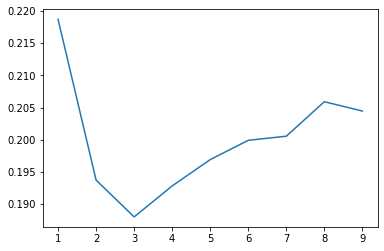

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot()
f = ax1.plot(range(1,10), avg_scores[0:9])

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

# !
Позвольте, напишу новый класс, просто, чтобы не изменять старый. Я боюсь что-то испортить, и придется заново всю эту штуку на фолдах считать

In [17]:
from numpy import linalg as LA

class MyyyCosKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        self.X_train = np.array(X).astype(float)
        self.y_train = np.array(y).astype(int)
        self.classes = np.unique(y).astype(int)
        self.num_of_classes = np.size(self.classes)
        if self.algorithm == 'brute':
            self.X_train_sqr = (self.X_train**2).sum(axis=1)

    def predict(self, X):
        X = np.array(X).astype(float)
        y_predicted = np.zeros(len(X)).astype(int)
        if self.algorithm == 'brute':
            X_sqr = (X**2).sum(axis=1)
            #distances = -2*np.dot(X, self.X_train.T) + np.tile(
            #    X_sqr, [len(self.X_train), 1]).T + np.tile(
            #    self.X_train_sqr, [len(X), 1])
            sim = np.dot(X, self.X_train.T) / LA.norm(X) / LA.norm(self.X_train)
            distances = 1 - sim
            for i in range(len(X)):
                indexes = np.argsort(distances[i, ])[:self.n_neighbors]
                y_predicted[i] = np.argmax(np.bincount(self.y_train[indexes]))
        return y_predicted

    def score(self, X, y):
        return np.mean(y == self.predict(X))

In [18]:
kf = KFold(n_splits=3)
avg_score = 0
for train_index, test_index in kf.split(ourdata):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = ourdata[train_index], ourdata[test_index]
    y_train, y_test = ourtarget[train_index], ourtarget[test_index]
    clf = MyyyCosKNeighborsClassifier(n_neighbors=1, algorithm='brute')
    clf.fit(X_train, y_train)
    avg_score += clf.score(X_test, y_test)
    print("current summary score is", avg_score)
avg_score = avg_score/3
print("avg_score =", avg_score)

TRAIN: [ 3668  3669  3670 ... 11001 11002 11003] TEST: [   0    1    2 ... 3665 3666 3667]


MemoryError: 

# Нужно больше оперативки, милорд
я честно уже все перепробовал(

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfdata = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(ourdata)

In [33]:
print(tfidfdata)

  (0, 65)	0.08875072014553223
  (0, 64)	0.08082820143276365
  (0, 63)	0.07741819058203513
  (0, 62)	0.09404584355595964
  (0, 61)	0.19931075718368177
  (0, 60)	0.04153982732066053
  (0, 59)	0.04199937208145752
  (0, 58)	0.10491567060975143
  (0, 57)	0.1094056402896926
  (0, 56)	0.046260775014792935
  (0, 55)	0.11061199091440235
  (0, 54)	0.08554667239835666
  (0, 53)	0.0754516645955041
  (0, 52)	0.1430912962507616
  (0, 51)	0.08316201109091532
  (0, 50)	0.14475914006605764
  (0, 49)	0.12689072448221486
  (0, 48)	0.09425261366404987
  (0, 47)	0.11544194288306746
  (0, 46)	0.22917718260254039
  (0, 45)	0.04942441607775907
  (0, 44)	0.0612963754103789
  (0, 43)	0.05328813436897419
  (0, 42)	0.06901579791490922
  (0, 41)	0.11445257087160239
  :	:
  (11003, 1739)	0.13147376463414592
  (11003, 1448)	0.1470773123826536
  (11003, 1394)	0.08586637296461364
  (11003, 1325)	0.15205710361740019
  (11003, 1311)	0.13279763908553632
  (11003, 1159)	0.1602434835676702
  (11003, 1130)	0.116257953073718

In [36]:
tfidfdata

<11004x72952 sparse matrix of type '<class 'numpy.float64'>'
	with 1077878 stored elements in Compressed Sparse Row format>

^ и что с этим делать?( 7 утра, извините, я уже немного прифигел

Но еще так как у нас лучший метод это 1 сосед, то веса эти ничего не должны поменять

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [45]:
newsgroups = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'])

In [46]:
data = newsgroups['data']
target = newsgroups['target']
print(len(data), len(target))
data[0]


7532 7532


'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.'

In [47]:
table = ''.join(chr(c) if chr(c).islower() else ' ' for c in range(256))
for i in range(len(data)):
    data[i] = data[i].lower().replace('\n',' ').translate(table).split()

data_tok = []
target_tok = []
for i in range(len(data)):
    if data[i]:
        data_tok.append(data[i])
        target_tok.append(target[i])

assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

indptr = [0]
indices = []
data = []
vocabulary = {}
for d in data_tok:
    for term in d:
        index = vocabulary.setdefault(term, len(vocabulary))
        indices.append(index)
        data.append(1)
    indptr.append(len(indices))

ourtarget = np.asarray(target_tok)
ourdata = scipy.sparse.csr_matrix((data,indices,indptr), dtype=int).todense()
ourdata = np.asarray(ourdata)

print(len(ourtarget), len(ourdata))

7307 7307


Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [50]:
cross_val_score(MyKNeighborsClassifier(1),ourdata,ourtarget,cv=3)

array([0.19484241, 0.20657084, 0.20090572])

In [51]:
(0.19484241+0.20657084+0.20090572)/3

0.20077299

In [52]:
kf = KFold(n_splits=3)
avg_score = 0
for train_index, test_index in kf.split(ourdata):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = ourdata[train_index], ourdata[test_index]
    y_train, y_test = ourtarget[train_index], ourtarget[test_index]
    clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute')
    clf.fit(X_train, y_train)
    avg_score += clf.score(X_test, y_test)
    print("current summary score is", avg_score)
avg_score = avg_score/3
print("avg_score =", avg_score)

TRAIN: [2436 2437 2438 ... 7304 7305 7306] TEST: [   0    1    2 ... 2433 2434 2435]
current summary score is 0.1863711001642036
TRAIN: [   0    1    2 ... 7304 7305 7306] TEST: [2436 2437 2438 ... 4869 4870 4871]
current summary score is 0.3899835796387521
TRAIN: [   0    1    2 ... 4869 4870 4871] TEST: [4872 4873 4874 ... 7304 7305 7306]
current summary score is 0.5891622244026125
avg_score = 0.19638740813420416


Скорее всего, отличалось бы сильно, если бы хватило памяти на косинусовое расстояние или ifidf

Лучше всех работал бы ifidf, полагаю, потому что веса это круто, а тем более такие крутые, как в ifidf